In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

from helper_functions import plot_decision_boundary

In [2]:
data = torch.tensor(
    [
        [0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]
    ]
)
labels = torch.tensor([0, 1, 1, 0])

In [3]:
torch.manual_seed(42)
hidden = 4
model = nn.Sequential(
    nn.Linear(2, hidden),
    nn.ReLU(),
    nn.Linear(hidden, 2)
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

In [4]:
epochs = 2000
for epoch in range(epochs):
    y_logits = model(data).squeeze()
    y_preds = torch.argmax(torch.sigmoid(y_logits), dim=1)
    
    loss = loss_fn(y_logits, labels)
    acc = accuracy_fn(labels, y_preds)

    if epoch % (epochs//10) == 0:
        print(f"[EPOCH {epoch+1}/{epochs}] Loss: {loss} | Accuracy: {acc}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()

[EPOCH 1/2000] Loss: 0.6882167458534241 | Accuracy: 50.0
[EPOCH 201/2000] Loss: 0.43064141273498535 | Accuracy: 75.0
[EPOCH 401/2000] Loss: 0.12646979093551636 | Accuracy: 100.0
[EPOCH 601/2000] Loss: 0.045105088502168655 | Accuracy: 100.0
[EPOCH 801/2000] Loss: 0.02384345605969429 | Accuracy: 100.0
[EPOCH 1001/2000] Loss: 0.015249533578753471 | Accuracy: 100.0
[EPOCH 1201/2000] Loss: 0.0109272301197052 | Accuracy: 100.0
[EPOCH 1401/2000] Loss: 0.008360976353287697 | Accuracy: 100.0
[EPOCH 1601/2000] Loss: 0.006700580008327961 | Accuracy: 100.0
[EPOCH 1801/2000] Loss: 0.0055505866184830666 | Accuracy: 100.0


(101, 101) (101, 101) (101, 101)


(-0.10000000149011612, 1.100000023841858)

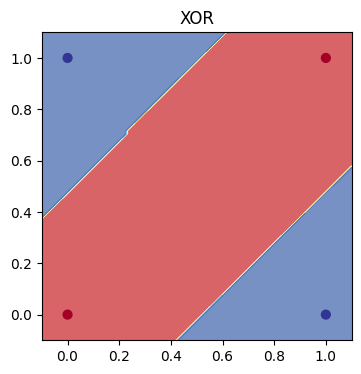

In [5]:
plt.figure(figsize=(4, 4))
plt.title("XOR")

x_min, x_max = data[:, 0].min() - 0.1, data[:, 0].max() + 0.1
y_min, y_max = data[:, 1].min() - 0.1, data[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

# Make features
X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

# Make predictions
model.eval()
with torch.inference_mode():
    y_logits = model(X_to_pred_on)

# Test for multi-class or binary and adjust logits to prediction labels
y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class

# Reshape preds and plot
y_pred = y_pred.reshape(xx.shape).detach().numpy()
print(xx.shape, yy.shape, y_pred.shape)
plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
plt.scatter(data[:, 0], data[:, 1], c=labels, s=40, cmap=plt.cm.RdYlBu)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [103]:
X = data.detach().numpy()
T = labels.detach().numpy()

In [104]:
# Extract weights and biases of trained MLP
layers = list(filter(None, [layer if isinstance(layer, nn.Linear) else None for layer in model.children()]))
W = [layer.weight.to('cpu').detach().numpy().T for layer in layers]
B = [layer.bias.to('cpu').detach().numpy().T for layer in layers]
L = len(W)
L, W[0].shape, W[1].shape

(2, (2, 4), (4, 2))

In [105]:
# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

In [106]:
i = np.random.randint(0, len(data))
prediction = np.argmax(A[L][i])
print(f"Point: {data[i]}, Pred: {prediction} | Label: {labels[i]}")

Point: tensor([0., 0.]), Pred: 0 | Label: 0


In [107]:
nb_labels = len(np.unique(labels))
#R = [None] * L + [A[L] * (T[:,None]==np.arange(nb_labels))]
R = [None] * L + [A[L]]

In [108]:
def rho(w, _l):
    return w
def incr(z, _l):
    return z

In [109]:
# All layers except the pixels one
for l in range(1, L)[::-1]:
    w = rho(W[l], l)
    b = rho(B[l], l)

    z = incr(A[l].dot(w)+b, l)
    s = R[l+1] / z
    c = s.dot(w.T)
    R[l] = A[l] * c

In [110]:
w = W[0]
wp = np.maximum(0, w)
wm = np.minimum(0, w)
lb = A[0]*0-1
hb = A[0]*0+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R[0] = A[0]*c - lb*cp - hb*cm

In [111]:
R[0].shape, R[1].shape, R[2].shape

((4, 2), (4, 4), (4, 2))

In [112]:
for i in range(len(data)):
    print(f"P: {data[i].tolist()} | Label: {labels[i]} | Relevance: {R[L][i]}")

P: [0.0, 0.0] | Label: 0 | Relevance: [2.891933 0.      ]
P: [0.0, 1.0] | Label: 1 | Relevance: [0.        3.4537249]
P: [1.0, 0.0] | Label: 1 | Relevance: [0.        3.1526463]
P: [1.0, 1.0] | Label: 0 | Relevance: [3.5345504 0.       ]


    [Layer 0] Relevance: [1.3729919 2.249682 ]
    [Layer 1] Relevance: [-4.5611605e-01 -7.1046750e-05  4.0788612e+00 -0.0000000e+00]
    [Layer 2] Relevance: [2.891933 0.      ]


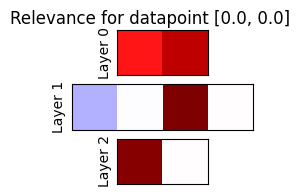

    [Layer 0] Activation: [0. 0.]
    [Layer 1] Activation: [9.3591964e-01 5.7245998e-05 1.7322453e+00 0.0000000e+00]
    [Layer 2] Activation: [2.891933 0.      ]


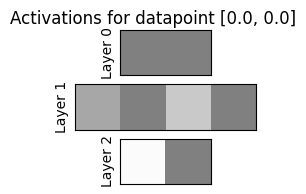

    [Layer 0] Relevance: [2.1210535  0.89093494]
    [Layer 1] Relevance: [ 1.5310686  1.9966259 -9.52092    9.005215 ]
    [Layer 2] Relevance: [0.        3.4537249]


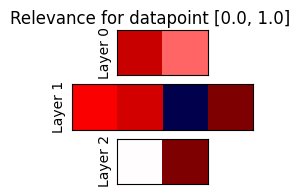

    [Layer 0] Activation: [0. 1.]
    [Layer 1] Activation: [1.2325523 1.4440066 4.056645  3.0023522]
    [Layer 2] Activation: [0.        3.4537249]


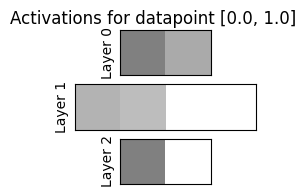

    [Layer 0] Relevance: [2.4236186  0.28729212]
    [Layer 1] Relevance: [ 2.7118378e+00  0.0000000e+00 -9.2692254e-04  0.0000000e+00]
    [Layer 2] Relevance: [0.        3.1526463]


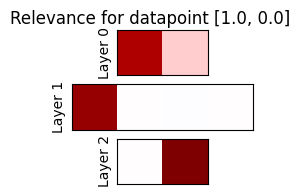

    [Layer 0] Activation: [1. 0.]
    [Layer 1] Activation: [2.1831040e+00 0.0000000e+00 3.9494038e-04 0.0000000e+00]
    [Layer 2] Activation: [0.        3.1526463]


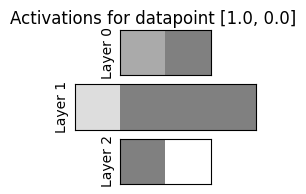

    [Layer 0] Relevance: [-0.9762862  5.2415776]
    [Layer 1] Relevance: [-1.2084880e+00 -3.3824090e-04  5.4741178e+00 -0.0000000e+00]
    [Layer 2] Relevance: [3.5345504 0.       ]


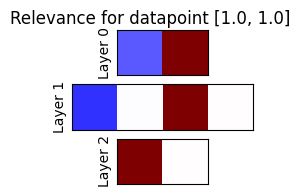

    [Layer 0] Activation: [1. 1.]
    [Layer 1] Activation: [2.4797366e+00 2.7253799e-04 2.3247948e+00 0.0000000e+00]
    [Layer 2] Activation: [3.5345504 0.       ]


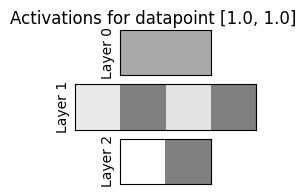

In [113]:
cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
cmap = ListedColormap(cmap)

for i in range(len(data)):
    #print(f"[POINT] {data[i].tolist()}")

    # -- Display relevance --
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        axs[l].imshow(R[l][i].reshape((1, len(R[l][i]))), cmap=cmap, interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        print(f"    [Layer {l}] Relevance: {R[l][i]}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    fig.suptitle(f"Relevance for datapoint {data[i].tolist()}")
    plt.show()

    # -- Display activations --
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        axs[l].imshow(A[l][i].reshape((1, len(A[l][i]))), cmap="gray", interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        print(f"    [Layer {l}] Activation: {A[l][i]}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    fig.suptitle(f"Activations for datapoint {data[i].tolist()}")
    plt.show()